In [1]:
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import cv2

import sys
# Get the previous folder and append it to sys.path
PATH = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(PATH)

from config import DATAFOLDER

In [2]:
dataset = 'Thebe'

split = 'train'  # train, val
ps = 256 # patch size
step = 3 # step size
stride = ps // 2

min_per = 50 # minimum % of fault pixels
pixels = int(min_per/100*ps*ps)

In [3]:
DATAPATH = os.path.join(DATAFOLDER, dataset)
DATAPATH2D = os.path.join(DATAPATH, 'Patches2D', 'tgt_ps{}to128_step{}'.format(ps, step) )
DATAPATH2D

'C:\\Users\\Usuario\\Documents\\Mestrado\\Tesis\\src\\datasets\\Thebe\\Patches2D\\src_ps256to128_step3'

## Read data

In [4]:
ld = os.listdir(DATAPATH)
ld = [x for x in ld if 'fault' + split in x ]
ld

['faulttrain1.npy',
 'faulttrain2.npy',
 'faulttrain3.npy',
 'faulttrain4.npy',
 'faulttrain5.npy',
 'faulttrain6.npy',
 'faulttrain7.npy',
 'faulttrain8.npy',
 'faulttrain9.npy']

In [7]:
seismic = []
for i in tqdm(range(len(ld))):
    i=i+1
    seis = np.load('{}/seis{}{}.npy'.format(DATAPATH, split, i)).astype(np.float32)
    seismic.append(seis)
    # break
    del seis
    
seismic = np.vstack(seismic)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:25<00:00,  2.84s/it]


In [8]:
seismic.shape   # IL, XL, Z

(900, 3174, 1537)

### Pre-Processing

In [9]:
# make it IL, Z, XL order
seismic = np.moveaxis(seismic,-2,-1) 

In [10]:
# scaling
mean_ = seismic.mean(axis=(1,2), keepdims=True)
std_ = seismic.std(axis=(1,2), keepdims=True)

print(mean_.shape)

seismic = (seismic - mean_)/std_

(900, 1, 1)


## Patch Generation

In [11]:
from dataloaders import PatchGenerator

seismic_slide = seismic[0]
h, w = seismic_slide.shape

patch_generator = PatchGenerator((h,w), ps, stride, phase='train')

nx, left_pad, right_pad, ny, top_pad, bottom_pad
24 13 13 12 63 64


In [12]:
seismic_patches_total = []
for il in tqdm(range(0, seismic.shape[0], step)):
    seismic_slide = seismic[il]
    
    seismic_patches = patch_generator.get_patches(seismic_slide) #get_patches(seismic_slide, ps, stride)
    
    # 50%: 86400 -> 41760
    seismic_patches_ = []
    for patch in seismic_patches:
        if np.unique(patch.ravel()).shape[0] > pixels:
            patch = np.expand_dims(patch, 0)
            seismic_patches_.append(patch)
    seismic_patches = np.vstack(seismic_patches_)
    
    seismic_patches_total.append(seismic_patches)
    del seismic_patches

del seismic
    
seismic_patches_total = np.vstack(seismic_patches_total)
seismic_patches_total.shape

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [01:57<00:00,  2.54it/s]


(41157, 256, 256)

In [13]:
# resize 256 to 128

new_size = (128, 128)

seismic_patches_total = np.vstack([
    np.expand_dims(cv2.resize(patch, new_size), axis=0) for patch in seismic_patches_total])

seismic_patches_total.shape

(41157, 128, 128)

### Ploting some of them

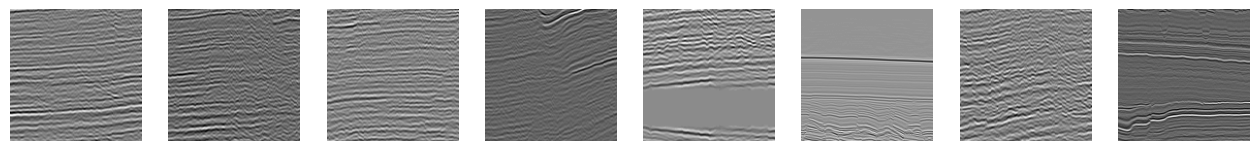

In [16]:
fig, axes = plt.subplots(1, 8, figsize=[16,2])
for i in range(8):
    ix = np.random.choice(len(seismic_patches_total))
    axes[i].imshow(seismic_patches_total[ix], cmap="gray")
    axes[i].axis('off')
    axes[i].axis('off')

### Saving

In [17]:
dir_imgs = "{}/{}/seismic".format(DATAPATH2D, split)
if not os.path.exists(dir_imgs):
    os.makedirs(dir_imgs)

In [18]:
for i in tqdm(range(len(seismic_patches_total))):
    np.save("{}/{}.npy".format(dir_imgs, i), seismic_patches_total[i])

100%|██████████████████████████████████████████████████████████████████████████| 41157/41157 [00:17<00:00, 2410.34it/s]
